In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u

# Pulling the Unresolved Binaries from O'Brien (Table A4)

In [2]:
query = """
SELECT
    gs.source_id,                
    gs.ra,                      
    gs.dec,                     
    gs.parallax,               
    gs.phot_g_mean_mag,  -- absolute
    gs.phot_g_mean_flux, -- apparent   
    gs.phot_bp_mean_mag,  -- absolute
    gs.phot_bp_mean_flux, -- apparent   
    gs.phot_rp_mean_mag,  -- absolute
    gs.phot_rp_mean_flux, -- apparent     
    ap.classprob_dsc_combmod_whitedwarf, 
    ap.classprob_dsc_combmod_binarystar,
    ap.teff_gspphot,
    ap.lum_flame,
    ap.radius_flame,
    ap.mass_flame
FROM
    gaiadr3.gaia_source AS gs   
LEFT JOIN
    gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE
    gs.source_id IN (
        1355264565043431040, 
        3223516063958808064,
        1005873614080407296,
        2185710338703934976,
        4788741548375134336,
        6431977687725247104,
        3729017810434416128,
        1548104507825815296,
        1550299304833675392,
        4478524169500496000,
        2643862402903084544,
        3845263368043086080,
        759601941671398272,
        3000597125173673088
    )
"""


In [3]:
job = Gaia.launch_job(query)
results = job.get_results()

# Galactocentric coordinates

In [4]:
# Turning the string into integers
parallax = results['parallax']
parallax = np.array(parallax)

ra = results['ra']
ra = np.array(ra)

dec = results['dec']
dec = np.array(dec)

#using parallax for postion 
arcsecond = parallax/1000
distance = abs(1/arcsecond)
coords = SkyCoord(ra*u.deg, dec*u.deg, distance*u.pc , frame='icrs')
galactic = coords.transform_to(Galactic)

#gives postions 
X = (galactic.cartesian.x)/u.pc
Y = (galactic.cartesian.y)/u.pc
Z = (galactic.cartesian.z)/u.pc

In [5]:
# Create a dictionary with the results and the boundary parameters
data = {
    'source_id' : results['source_id'],
    'ra' : results['ra'],
    'dec' : results['dec'],
    'parallax' : results['parallax'],
    'G_mag' : results['phot_g_mean_mag'],
    'g_flux' : results['phot_g_mean_flux'],         # [e/s]
    'BP_mag' : results['phot_bp_mean_mag'],
    'bp_flux' : results['phot_bp_mean_flux'],       # [e/s]
    'RP_mag' : results['phot_rp_mean_mag'],
    'rp_flux' : results['phot_rp_mean_flux'],       # [e/s]
    'WD_prob' : results['classprob_dsc_combmod_whitedwarf'],
    'Binary_prob' : results['classprob_dsc_combmod_binarystar'],
    'T_eff' : results['teff_gspphot'],
    'lum_flame' : results['lum_flame'],
    'radius_flame' : results['radius_flame'],
    'mass_flame' : results['mass_flame'],
    'X' : X,
    'Y' : Y,
    'Z' : Z 
}
#df = pd.DataFrame(data)

In [6]:
# plt.scatter(df['X'], df['Y'], c='k', s=5)
# plt.xlabel('X axis (pc)')
# plt.ylabel('Y axis (pc)')

# Exposure Times

In [7]:
# when the bands get saturated 
Sat_lim_UVB = 41300     #e
Sat_lim_VIS = 41900     #e
Sat_lim_NIR = 103000    #e
# We decided to go with a SNR of 500 
SNR = 500

In [8]:
# # Testing the math
# e_count = SNR**2

# bp = df['bp_flux'][10] 
# g = df['g_flux'][10]
# rp = df['rp_flux'][10]

# # min exposure time per band 
# min_time_uvb = e_count / bp     #[sec]
# print(min_time_uvb)
# min_time_vis = e_count / g      #[sec]
# min_time_nir = e_count / rp     #[sec]

# # Time it takes for the filter to become saturated
# S_time_uvb = Sat_lim_UVB / bp          #[sec]
# print(S_time_uvb)
# S_time_vis = Sat_lim_VIS / g           #[sec]
# S_time_nir = Sat_lim_NIR / rp          #[sec]
    
# # Get the whole number of exposures to prevent saturation, then add 1
# Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
# print(Num_exp_uvb)
# Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
# Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

# # Time for each exposure, based on what is smaller, saturation time or the min time 
# Time_per_uvb = min_time_uvb / Num_exp_uvb
# print(Time_per_uvb)
# Time_per_vis = min_time_vis / Num_exp_vis
# Time_per_nir = min_time_nir / Num_exp_nir

# print('UVB:', Num_exp_uvb, Time_per_uvb, (Num_exp_uvb * Time_per_uvb))
# print('VIS:', Num_exp_vis, Time_per_vis, (Num_exp_vis * Time_per_vis))
# print('NIR:', Num_exp_nir, Time_per_nir, (Num_exp_nir * Time_per_nir))

# ### Cool it works lets make it a function to automate over all the candidates & append the values 

In [9]:
# SNR, next 3 are the flux for each source, next 3 are the saturation constants
def min_exp(SNR, bp, g, rp, S_bp, S_g, S_rp):
    # SNR = N**(1/2), therefore we need an electron count of 
    e_count = SNR**2

    # min exposure time per band 
    min_time_uvb = e_count / bp     #[sec]
    min_time_vis = e_count / g      #[sec]
    min_time_nir = e_count / rp     #[sec]

    # Time it takes for the filter to become saturated
    S_time_uvb = S_bp / bp          #[sec]
    S_time_vis = S_g / g            #[sec]
    S_time_nir = S_rp / rp          #[sec]
    
    # Get the whole number of exposures to prevent saturation, then add 1
    Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
    Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
    Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

    # Time for each exposure 
    Time_per_uvb = min_time_uvb / Num_exp_uvb
    Time_per_vis = min_time_vis / Num_exp_vis
    Time_per_nir = min_time_nir / Num_exp_nir

    return  {
        'Num_exp_uvb': Num_exp_uvb,
        'Time_per_uvb': Time_per_uvb,
        'Total_time_uvb': Num_exp_uvb * Time_per_uvb,

        'Num_exp_vis': Num_exp_vis,
        'Time_per_vis': Time_per_vis,
        'Total_time_vis': Num_exp_vis * Time_per_vis,

        'Num_exp_nir': Num_exp_nir,
        'Time_per_nir': Time_per_nir,
        'Total_time_nir': Num_exp_nir * Time_per_nir,
    }

In [10]:
def times(row):
    return min_exp(
        SNR=SNR,
        bp=row['bp_flux'],
        g=row['g_flux'],
        rp=row['rp_flux'],
        S_bp=Sat_lim_UVB,
        S_g=Sat_lim_VIS,
        S_rp=Sat_lim_NIR
    )

# exp_results = df.apply(times, axis=1)

# exp_df = pd.DataFrame(exp_results.tolist())
# df = pd.concat([df, exp_df], axis=1)

# Saving the Data

In [11]:
#df.to_csv('Exposure_time_estimates.csv', index=False)

# Call on the file

In [12]:
# Uncomment for Macbook Pro
#df = pd.read_csv('/Users/izaihamartinez/Downloads/School/Observational Tech/Exposure_time_estimates.csv')
# Uncomment for Macbook Air
df = pd.read_csv('/Users/izaihamartinez/Downloads/School/Courses/UA-Obs-Tech/Exposure_time_estimates.csv')
# Uncomment for PC
#df = pd.read_csv(r'C:\Users\izaih\Downloads\UA\Courses\UA-Obs-Tech\Exposure_time_estimates.csv')

# Looking at the RA & DEC 

Text(0, 0.5, 'dec (deg)')

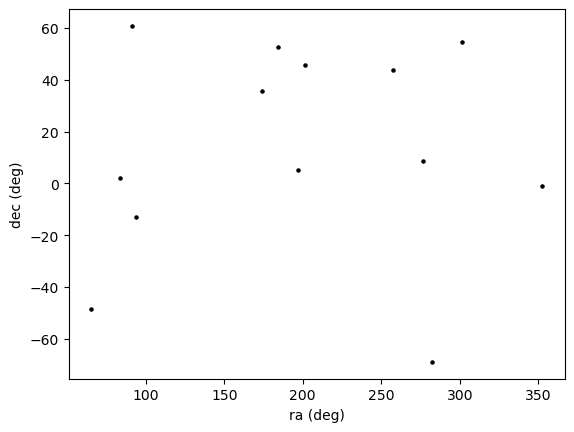

In [13]:
plt.scatter(df['ra'], df['dec'], c='k', s=5)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

# Using Astroplan

In [14]:
#pip install astroplan

In [15]:
from astroplan import Observer, FixedTarget, ObservingBlock
from astroplan.constraints import AtNightConstraint, AirmassConstraint, TimeConstraint
from astroplan.scheduling import Transitioner, PriorityScheduler, Schedule
from astroplan.plots import plot_schedule_airmass
from astropy.time import Time
from datetime import timedelta

In [16]:
# I need to set the location to VLT, it is at the Cerro Paranal, Mountain
vlt_location = Observer.at_site('paranal')

# astroplan uses icrs coordinate system 
coords = [SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs') for ra, dec in zip(df['ra'], df['dec'])]

# create a target list 

# added names so we can see which targets are observable 
names = [f"T{i+1}" for i in range(len(coords))]
targets = [FixedTarget(coord=coord, name=name) for coord, name in zip(coords, names)]

# added the targets to the df 
df['targets'] = targets

In [17]:
targets

[<FixedTarget "T1" at SkyCoord (ICRS): (ra, dec) in deg (173.92634511, 35.57310957)>,
 <FixedTarget "T2" at SkyCoord (ICRS): (ra, dec) in deg (91.37515254, 60.81940106)>,
 <FixedTarget "T3" at SkyCoord (ICRS): (ra, dec) in deg (257.38347212, 43.68010581)>,
 <FixedTarget "T4" at SkyCoord (ICRS): (ra, dec) in deg (183.93308097, 52.51643833)>,
 <FixedTarget "T5" at SkyCoord (ICRS): (ra, dec) in deg (201.72067979, 45.54552053)>,
 <FixedTarget "T6" at SkyCoord (ICRS): (ra, dec) in deg (301.25028584, 54.43021427)>,
 <FixedTarget "T7" at SkyCoord (ICRS): (ra, dec) in deg (352.37627645, -1.03600386)>,
 <FixedTarget "T8" at SkyCoord (ICRS): (ra, dec) in deg (93.9337227, -12.79141488)>,
 <FixedTarget "T9" at SkyCoord (ICRS): (ra, dec) in deg (83.43563712, 1.94471918)>,
 <FixedTarget "T10" at SkyCoord (ICRS): (ra, dec) in deg (197.21297744, 5.20421688)>,
 <FixedTarget "T11" at SkyCoord (ICRS): (ra, dec) in deg (276.59053098, 8.61367713)>,
 <FixedTarget "T12" at SkyCoord (ICRS): (ra, dec) in deg (

- UTC is 5 hours ahead of Tuscaloosa 
- UTC is 4 hours ahead of VLT 

In [18]:
# # Need to define the observing time (aka night time)
# noon_before = Time('2025-07-06 19:00')
# noon_after = Time('2025-07-07 19:00')
# # I am going to put a week
# start = Time('2025-07-06 19:00')
# end = Time('2025-07-15 19:00')

In [19]:
# this will allow me to constrain the observations to the night time & airmass

# Define constraints (taken from the docmentation example)
global_constraints = [AirmassConstraint(max = 3, boolean_constraint = False),
                      AtNightConstraint.twilight_civil()]

In [20]:
# observing blocks for each object with the exposure times and number of exposures from above
read_out = 20 * u.second
blocks = []

for idx, row in df.iterrows():    
    # Use the calculated exposure time and number of exposures for each filter
    block_uvb = ObservingBlock.from_exposures(
        row['targets'], 
        priority=1, 
        time_per_exposure=row['Time_per_uvb']*u.second, 
        number_exposures=row['Num_exp_uvb'],
        readout_time=read_out, 
        configuration = {'filter': 'UVB'},
        constraints=global_constraints
    )
    blocks.append(block_uvb)

    block_vis = ObservingBlock.from_exposures(
        row['targets'], 
        priority=2, 
        time_per_exposure=row['Time_per_vis']*u.second, 
        number_exposures=row['Num_exp_vis'],
        readout_time=read_out, 
        configuration = {'filter': 'VIS'},
        constraints=global_constraints
    )
    blocks.append(block_vis)

    block_nir = ObservingBlock.from_exposures(
        row['targets'], 
        priority=3, 
        time_per_exposure=row['Time_per_nir']*u.second, 
        number_exposures=row['Num_exp_nir'],
        readout_time=read_out, 
        configuration = {'filter': 'NIR'},
        constraints=global_constraints
    )
    blocks.append(block_nir)

In [21]:
# Initialize a transitioner object with the slew rate and/or the duration of other transitions (e.g. filter changes)
slew_rate = 1*u.deg/u.second    # value found in the manual of VLT  (vista_0p975.dvi)
transitioner = Transitioner(slew_rate,
                            {'filter':{('UVB','VIS'): 10*u.second,
                                       ('VIS','NIR'): 10*u.second,
                                       'default': 30*u.second}})
# I couldn't find the time needed to switch the filters so I am using the values the documentation used 

Some notes on using these imports 
- Need numpy version 1.25
- Need astropy version 5.3.4

Otherwise there will be issues when running the seq_schedular

In [22]:
####### DON'T RUN THIS ONE | IT WASTES TIME | OTHER ONE PRIORITIZES, SO IT WILL RUN FASTER ########
# from astroplan.scheduling import SequentialScheduler
# # Initialize the sequential scheduler with the constraints and transitioner
# seq_scheduler = SequentialScheduler(constraints = global_constraints,
#                                     observer = vlt_location,
#                                     transitioner = transitioner)
# # Initialize a Schedule object, to contain the new schedule
# sequential_schedule = Schedule(noon_before, noon_after)

# # Call the schedule with the observing blocks and schedule to schedule the blocks
# seq_scheduler(blocks, sequential_schedule)

In [23]:
# I need to automate this

def schedule_one_night(start, end, blocks, month="", night_label=""):
    # Initialize the priority scheduler with the constraints and transitioner
    prior_scheduler = PriorityScheduler(constraints = global_constraints,
                                        observer = vlt_location,
                                        transitioner = transitioner)
    # Initialize a Schedule object, to contain the new schedule
    schedule = Schedule(start, end)
    # Call the schedule with the observing blocks and schedule to schedule the blocks
    prior_scheduler(blocks, schedule)
    prior_scheduler(blocks, schedule)
    prior_scheduler(blocks, schedule)
    prior_scheduler(blocks, schedule)    
    prior_scheduler(blocks, schedule)
    prior_scheduler(blocks, schedule)    
    prior_scheduler(blocks, schedule)
    # plot the schedule with the airmass of the targets
    # plt.figure(figsize = (14,6))
    # plot_schedule_airmass(schedule)
    # plt.title(f"Schedule for {night_label}")
    # plt.legend(loc = "upper right", fontsize="small") 
    # plt.savefig(f"/Users/izaihamartinez/Downloads/School/Courses/UA-Obs-Tech/{month}/Schedule_for_{night_label}.png") ##### if running on my macbook air
    # #plt.savefig(f"/Users/izaihamartinez/Downloads/School/Observational Tech/{month}/Schedule_for_{night_label}.png") ##### if running on my macbook pro
    # plt.show()


    return schedule 


In [24]:
###### The individual test ########
 
#since I want to run this over months (start is 17:00 local, 21:00 UTC)
# jan_start = Time('2026-01-01 21:00')
# jan_end = Time('2026-01-31 11:00')

# july_start = Time('2026-07-01 21:00')
# july_end = Time('2026-07-31 11:00')

# dec_start = Time('2026-12-01 21:00')
# dec_end = Time('2026-12-30 11:00')
# start_night = Time('2026-01-01 21:00')
# end_night = Time('2026-01-02 11:00')


# all_schedules = []
# # I need to start the counter at the 1st day 
# current_night = start_night
# while current_night < end_night:
#     night_start = current_night
#     # the new night end will be the next day morning (roughly 8AM local, therefore that would be 14 hours of testing)
#     night_end = current_night + timedelta(hours= 14)

#     label = night_start.iso.split()[0]
#     schedule = schedule_one_night(night_start, night_end, blocks, month="Dec", night_label=label)
#     all_schedules.append(schedule)
#     # now we shift by a full day to the start night time (this is how we skip the day time)
#     current_night += timedelta(days=1)

In [25]:
# #Don't run yet

# all_schedules = []
# #months you can't do (for no reason)= ["02", "11"]
# months = ["03", "04", "05", "06", "07", "08", "09", "10", "11" "12"]  # I will loop over the months

# for month in months:
#     start_night = Time(f"2026-{month}-01 21:00")
#     end_night = Time(f"2026-{month}-30 11:00")

#     current_night = start_night
#     while current_night < end_night:
#         night_start = current_night
#         night_end = current_night + timedelta(hours=14)

#         label = night_start.iso.split()[0]
#         schedule = schedule_one_night(night_start, night_end, blocks, month=month, night_label=label)
#         all_schedules.append(schedule)

#         current_night += timedelta(days=1)

Based on the plots from above, these days are best for observing

For the Year 2025:

- 2025-01-26: T10, T1, T7, T8, T9, T5, T12, T13
- 2025-07-09 to 21: T10, T1, T11, T7, T8, T9, T3, T13, T12, T5
- 2025-12-01 to 21: T10, T1, T7, T8, T9, T12, T13

For the Year 2026:

- 2026-01-18 to 29: T12, T5, T13, T1, T10, T7, T8, T9 
- 2026-03-01 to 29: T13, T11, T8, T1, T9, T3, T12, T5, T10 
- 2026-04-01 to 29: T13, T11, T8, T1, T9, T3, T12, T5, T10 
- 2026-05-01 to 21: T11, T13, T7, T8, T1, T9, T3, T12, T5, T10 
- 2026-06-01 to 12: T12, T5, T13, T10, T11, T7, T8, T1, T3
- 2026-07-10 to 21: T11, T13, T7, T8, T1, T9, T3, T12, T5, T10
- 2026-08-01 to 29: T11, T7, T8, T9, T3, T12, T13, T10
- 2026-09-01 to 08: T11, T7, T8, T9, T3, T12, T13, T10
- 2026-11-01 to 29: T11, T7, T8, T9, T12, T13
- 2026-12-01 to 22: T12, T13, T1, T10, T7, T8, T9

In [26]:
#df_schedule = pd.DataFrame(all_schedules)
#df_schedule.to_csv("2026_rest_Schedule.csv", index=False)

# Going to fill the nights now 

We should ask for nights in May & July with these targets: 
- T1, T3, T5, T7, T8, T9, T10, T11, T12, T13
- Ask for 3ish days in each month
- 3 back to back days in May 
- 3 spread out days in July 
- This would help create the radial velocity plot

These WD binaries could be progenators to:
- Hot DQs
- SN Ia (if they are close binaries)
- High total mass (>1.4) = super-Chandra mass

Read: A super-Chandrasekhar mass type Ia supernova progenitor at 49 pc set to detonate in 23 Gyr
- they have code we can use for the spectra

The Light cuves tell us, that the approximate periods are: 

- T1: ~22 days 
- T3: ~15 days
- T5: ~20 days (good light curve to use for proposal/talk)
- T7: ~17 days
- T8: ~8 days
- T9: ~10 days
- T10: ~10 days
- T11: ~10 days (Inconclusive)
- T12: ~12 days
- T13: ~10 days 

Notes to make:
- The very 'polluted' light curves are very low flux, therefore the SNR is bad and they appear polluted
- Some have many peaks (could be more than a binary system, part of the goal)

In [27]:
# Dropping T2, T4, & T6 
block = [b for b in blocks if b.target.name not in ['T2', 'T4', 'T6']]

In [28]:
may_schedules = []
#going to run for the specific days we want in May
months = ["05"]  
## days we want, changed the interval in the last line, this code segment also prints the schedule 
#days = ['01', '03', '05', '07', '09', '11', '13', '15', '17', '19', '21']

for month in months:
    start_night = Time(f"2026-{month}-01 21:00")
    end_night = Time(f"2026-{month}-21 11:00")

    current_night = start_night
    while current_night < end_night:
        night_start = current_night
        night_end = current_night + timedelta(hours=14)

        label = night_start.iso.split()[0]
        schedule = schedule_one_night(night_start, night_end, block, month=month, night_label=label)
        may_schedules.append(schedule)

        print(schedule.to_table())

        current_night += timedelta(days=2)

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-01 22:37:20.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-01 22:54:40.004 ...                    []
             T9 2026-05-01 22:55:00.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-01 22:57:20.004 ...                    []
            T12 2026-05-01 22:58:20.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-01 23:00:40.004 ... ['filter:UVB to VIS']
             T8 2026-05-01 23:01:40.004 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-01 23:07:20.004 ...                    []
             T9 2026-05-01 23:07:40.004 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-01 23:09:40.004 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-02 10:25:20.029 ... ['filter:NIR to VIS']
             T7 2026-05-02 10:26:20.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-03 22:36:00.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-03 22:53:20.004 ...                    []
             T9 2026-05-03 22:53:40.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-03 22:56:00.004 ...                    []
            T12 2026-05-03 22:57:00.004 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-03 22:59:20.004 ... ['filter:UVB to VIS']
             T8 2026-05-03 23:00:20.004 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-03 23:06:00.004 ...                    []
             T9 2026-05-03 23:06:20.004 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-03 23:08:20.004 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-04 10:26:20.030 ... ['filter:NIR to VIS']
             T7 2026-05-04 10:27:20.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-05 22:35:00.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-05 22:52:20.003 ...                    []
             T9 2026-05-05 22:52:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-05 22:55:00.003 ...                    []
            T12 2026-05-05 22:56:00.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-05 22:58:20.003 ... ['filter:UVB to VIS']
             T8 2026-05-05 22:59:20.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-05 23:05:00.003 ...                    []
             T9 2026-05-05 23:05:20.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-05 23:07:20.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-06 10:27:20.030 ... ['filter:NIR to VIS']
             T7 2026-05-06 10:28:20.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-07 22:33:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-07 22:51:00.003 ...                    []
             T9 2026-05-07 22:51:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-07 22:53:40.003 ...                    []
            T12 2026-05-07 22:54:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-07 22:57:00.003 ... ['filter:UVB to VIS']
             T8 2026-05-07 22:58:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-07 23:03:40.003 ...                    []
             T9 2026-05-07 23:04:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-07 23:06:00.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-08 10:28:00.030 ... ['filter:NIR to VIS']
             T7 2026-05-08 10:29:00.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-09 22:32:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-09 22:50:00.003 ...                    []
             T9 2026-05-09 22:50:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-09 22:52:40.003 ...                    []
            T12 2026-05-09 22:53:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-09 22:56:00.003 ... ['filter:UVB to VIS']
             T8 2026-05-09 22:57:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-09 23:02:40.003 ...                    []
             T9 2026-05-09 23:03:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-09 23:05:00.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-10 10:29:00.030 ... ['filter:NIR to VIS']
             T7 2026-05-10 10:30:00.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-11 22:31:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-11 22:49:00.003 ...                    []
             T9 2026-05-11 22:49:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-11 22:51:40.003 ...                    []
            T12 2026-05-11 22:52:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-11 22:55:00.003 ... ['filter:UVB to VIS']
             T8 2026-05-11 22:56:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-11 23:01:40.003 ...                    []
             T9 2026-05-11 23:02:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-11 23:04:00.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-12 10:30:00.030 ... ['filter:NIR to VIS']
             T7 2026-05-12 10:31:00.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-13 22:30:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-13 22:48:00.003 ...                    []
             T9 2026-05-13 22:48:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-13 22:50:40.003 ...                    []
            T12 2026-05-13 22:51:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-13 22:54:00.003 ... ['filter:UVB to VIS']
             T8 2026-05-13 22:55:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-13 23:00:40.003 ...                    []
             T9 2026-05-13 23:01:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-13 23:03:00.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-14 10:31:00.030 ... ['filter:NIR to VIS']
             T7 2026-05-14 10:32:00.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-15 22:29:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-15 22:47:00.003 ...                    []
             T9 2026-05-15 22:47:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-15 22:49:40.003 ...                    []
            T12 2026-05-15 22:50:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-15 22:53:00.003 ... ['filter:UVB to VIS']
             T8 2026-05-15 22:54:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-15 22:59:40.003 ...                    []
             T9 2026-05-15 23:00:00.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-15 23:02:00.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-16 10:31:40.030 ... ['filter:NIR to VIS']
             T7 2026-05-16 10:32:40.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-17 22:29:00.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-17 22:46:20.003 ...                    []
             T9 2026-05-17 22:46:40.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-17 22:49:00.003 ...                    []
            T12 2026-05-17 22:50:00.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-17 22:52:20.003 ... ['filter:UVB to VIS']
             T8 2026-05-17 22:53:20.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-17 22:59:00.003 ...                    []
             T9 2026-05-17 22:59:20.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-17 23:01:20.003 ...                    []
            ...                     ... ...                   ...
TransitionBlock 2026-05-18 10:32:40.030 ... ['filter:NIR to VIS']
             T7 2026-05-18 10:33:40.030 ...     {'filter': 'VIS'}
Transition

     target         start time (UTC)    ...     configuration    
--------------- ----------------------- ... ---------------------
             T8 2026-05-19 22:28:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-19 22:45:40.003 ...                    []
             T9 2026-05-19 22:46:00.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-19 22:48:20.003 ...                    []
            T12 2026-05-19 22:49:20.003 ...     {'filter': 'UVB'}
TransitionBlock 2026-05-19 22:51:40.003 ... ['filter:UVB to VIS']
             T8 2026-05-19 22:52:40.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-19 22:58:20.003 ...                    []
            T12 2026-05-19 22:59:20.003 ...     {'filter': 'VIS'}
TransitionBlock 2026-05-19 23:01:20.003 ... ['filter:VIS to NIR']
            ...                     ... ...                   ...
TransitionBlock 2026-05-20 10:33:40.030 ... ['filter:NIR to VIS']
             T7 2026-05-20 10:34:40.030 ...     {'filter': 'VIS'}
Transition

In [29]:
# We honestly don't need July

# july_schedules = []
# #going to run for the specific days we want in July
# months = ["07"]  
# days = ['', '']

# for month in months:
#     start_night = Time(f"2026-{month}-10 21:00")
#     end_night = Time(f"2026-{month}-21 11:00")

#     current_night = start_night
#     while current_night < end_night:
#         night_start = current_night
#         night_end = current_night + timedelta(hours=14)

#         label = night_start.iso.split()[0]
#         schedule = schedule_one_night(night_start, night_end, block, month=month, night_label=label)
#         july_schedules.append(schedule)

#         print(schedule.to_table())

#         current_night += timedelta(days=1)